# Image classification workflow with distributed training
The following example demonstrates an end to end data science workflow for building an an image classifier <br>
The model is trained on an images dataset of cats and dogs. Then the model is deployed as a function in a serving layer <br>
Users can send http request with an image of cats/dogs image and get a respond back that identify whether it is a cat or a dog

This typical data science workflow comprises of the following:
* Download anb label the dataset
* Training a model on the images dataset
* Deploy a function with the new model in a serving layer
* Testing the function

Key technologies:
* Tensorflow-Keras for training the model
* Horovod for running a distributed training
* MLRun (open source library for tracking experiments https://github.com/mlrun/mlrun) for building the functions and tracking experiments
* Nuclio function for creating a funciton that runs the model in a serving layer

This demo is based on the following:<br>
* https://github.com/tensorflow/docs/tree/master/site/en/tutorials
* https://www.kaggle.com/uysimty/keras-cnn-dog-or-cat-classification/log

In [2]:
# nuclio: ignore
import nuclio

## Helper functions for downloading and labeling images
In the code below we have two functions: 
1. open_archive - Get and extract a zip file that contains cats and dog images. users need to pass the source URL and the target directory which is stored in Iguazio data layer
2. categories_map_builder - labeling the dataset based on the file name. the functions creates a pandas dataframe with the filename and category (i.e. cat & dog)

Note that sometime after running pip install you need to restart the jupyer kernel

#### Function config and code

In [3]:
import os
import zipfile
import json
from tempfile import mktemp
import pandas as pd
from mlrun import DataItem

# download the image archive
def open_archive(context, 
                 archive_url: DataItem,
                 target_path,
                 refresh=False):
    """Open a file/object archive into a target directory
    
    Currently supports zip and tar.gz
    
    :param context:      function execution context
    :param archive_url:  url of archive file
    :param target_path:  file system path to store extracted files
    :param key:          key of archive contents in artifact store
    """
    os.makedirs(target_path, exist_ok=True)
    
    # get the archive as a local file (download if needed)
    archive_url = archive_url.local()
    
    context.logger.info('Extracting zip')
    zip_ref = zipfile.ZipFile(archive_url, 'r')
    zip_ref.extractall(target_path)
    zip_ref.close()
    
    context.logger.info(f'extracted archive to {target_path}')
    context.log_artifact('content', target_path=target_path)

    
# build categories 
def categories_map_builder(context,
                           source_dir,
                           df_filename='file_categories_df.csv',
                           map_filename='categories_map.json'):
    """Read labeled images from a directory and create category map + df
    
    filename format: <category>.NN.jpg"""
    
    # create filenames list (jpg only)
    filenames = [file for file in os.listdir(source_dir) if file.endswith('.jpg')]
    categories = []
        
    # Create a pandas DataFrame for the full sample
    for filename in filenames:
        category = filename.split('.')[0]
        categories.append(category)

    df = pd.DataFrame({
        'filename': filenames,
        'category': categories
    })
    df['category'] = df['category'].astype('str')
    
    categories = df.category.unique()
    categories = {i: category for i, category in enumerate(categories)}
    with open(os.path.join(context.artifact_path, map_filename), 'w') as f:
        f.write(json.dumps(categories))
        
    context.logger.info(categories)
    context.log_artifact('categories_map', local_path=map_filename)
    context.log_dataset('file_categories', df=df, local_path=df_filename)

In [4]:
# nuclio: end-code

### mlconfig

Set the MLRun database location and the base directory

In [5]:
from os import environ, path
from mlrun import mlconf

In [6]:
mlconf.dbpath = mlconf.dbpath or 'http://mlrun-api:8080'
mlconf.artifact_path = mlconf.artifact_path or f'{environ["HOME"]}/artifacts'

In [7]:
# set tensorflow version (v1 or v2)
tf_ver = 'v2'

In [8]:
# specify paths and artifacts target location
code_dir = path.join(path.abspath('./'), 'src-tf' + tf_ver) # Where our source code files are saved
images_path = path.join(mlconf.artifact_path, 'images') 
code_dir, images_path

('/User/mlrun-demos/demos/image-classification-with-distributed-training/src-tfv2', '/User/artifacts/images')

In [9]:
project_name='cat-and-dog-servers'

### Test locally, Download and extract image archive
The dataset is taken from the Iguazio-sample bucket in S3 <br>
>Note that this step is captured in the MLRun database. <br>

We create a new local function with our inline code from above.  
We then define a `NewTask` with the `open_archive` function handler and the needed parameters and run it.  

In [10]:
# download images from s3 using the local `open_archive` function
from mlrun import NewTask, run_local

open_archive_task = NewTask(name='download', 
                            handler=open_archive, 
                            params={'target_path': images_path},
                            inputs={'archive_url': 'http://iguazio-sample-data.s3.amazonaws.com/catsndogs.zip'})


download_run = run_local(open_archive_task, 
                         project=project_name)

> 2020-10-19 11:22:25,143 [info] starting run download uid=4c348582ba6f4b14b32ca5401135898f  -> http://mlrun-api:8080
> 2020-10-19 11:22:25,213 [info] downloading http://iguazio-sample-data.s3.amazonaws.com/catsndogs.zip to local tmp
> 2020-10-19 11:22:38,156 [info] Extracting zip
> 2020-10-19 11:22:43,308 [info] extracted archive to /User/artifacts/images


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
cat-and-dog-servers,...1135898f,0,Oct 19 11:22:25,completed,download,v3io_user=adminkind=handlerowner=adminhost=jupyter-7845f5fb96-b2hl5,archive_url,target_path=/User/artifacts/images,,content


to track results use .show() or .logs() or in CLI: 
!mlrun get run 4c348582ba6f4b14b32ca5401135898f --project cat-and-dog-servers , !mlrun logs 4c348582ba6f4b14b32ca5401135898f --project cat-and-dog-servers
> 2020-10-19 11:22:43,414 [info] run executed, status=completed


# Complete Data-Science Pipeline with MLRun and Kubeflow

We are using a library called MLRun for running the functions and storing the experiments meta data in the MLRun database <br>
Users can query the database to view all the experiments along with their associated meta data <br>
- Get data
- Create categories map
- Train horovod model on the cluster
- Deploy model

## Create a multi-stage project (ingest, label, train, deploy model)

Projects are used to package multiple functions, workflows, and artifacts. We usually store project code and definitions in a Git archive.

The following code creates a new project in a local dir and initialize git tracking on that

In [11]:
from mlrun import new_project, code_to_function
project_dir = './'
hvdproj = new_project(project_name, project_dir)

#### Add our `utils` function to the project
We convert our inline (notebook) code to a function object and register that under our project

In [12]:
utils = code_to_function(kind='job', 
                         name='utils',
                         image='mlrun/mlrun')

In [13]:
hvdproj.set_function(utils)

#### Run/test our function on the cluster 
We define a `NewTask` using the `categories_map_builder` function handler and the needed parameters.
We add Iguazio v3io file mount (share the local paths with our function) and run the task remotely 

In [14]:
# Create categories map
label_task = NewTask(
    name='label', 
    handler=categories_map_builder, 
    params={'source_dir': os.path.join(download_run.output('content'), 'cats_n_dogs'),
            'map_filename': 'categories_map.json'})

In [15]:
from mlrun import mount_v3io
hvdproj.func('utils').apply(mount_v3io()).run(label_task)

> 2020-10-19 11:22:47,052 [info] starting run label uid=bbe235a8a048495aacf94c7157dbf569  -> http://mlrun-api:8080
> 2020-10-19 11:22:47,172 [info] Job is running in the background, pod: label-d6pwq
> 2020-10-19 11:22:51,457 [info] {0: 'cat', 1: 'dog'}
> 2020-10-19 11:22:51,564 [info] run executed, status=completed
final state: succeeded


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
cat-and-dog-servers,...57dbf569,0,Oct 19 11:22:51,completed,label,v3io_user=adminkind=jobowner=adminhost=label-d6pwq,,source_dir=/User/artifacts/images/cats_n_dogsmap_filename=categories_map.json,,categories_mapfile_categories


to track results use .show() or .logs() or in CLI: 
!mlrun get run bbe235a8a048495aacf94c7157dbf569 --project cat-and-dog-servers , !mlrun logs bbe235a8a048495aacf94c7157dbf569 --project cat-and-dog-servers
> 2020-10-19 11:22:53,309 [info] run executed, status=completed


### Define a new function for distributed Training with TensorFlow, Keras and Horovod

Here we use the same structure as before to deploy our **[cats vs. dogs tensorflow model training file](horovod-training.py)** to run on the defined horovod cluster in a distributed manner.  

1. Define the input parameters for the training function.  
2. Set the function's `kind='mpijob'` to let MLRun know to apply the job to the MPI CRD and create the requested horovod cluster.  
3. Set the number of workers for the horovod cluster to use by setting `trainer.spec.replicas = 4` (default is 1 replica).  

#### To run training using GPUs
To provide GPU support for our workers we need to add this two steps
1. Set the function image to a CUDA enabled image (Required) with GPU versions of the frameworks (if needed - TF 1.x gpu version for example)
2. Set the number of GPUs **each worker** will receive by setting `trainer.gpus(1)` (default is 0 GPUs).
> Please verify that the `HOROVOD_FILE` path is available from the cluster (Local path and Mounted path may vary)

In [16]:
from mlrun import new_function

# Set `use_gpu` to True to run the function using a GPU
use_gpu = False

image = lambda gpu: 'mlrun/ml-models-gpu' if gpu else 'mlrun/ml-models' 

# Set basic function parameters
HOROVOD_FILE = os.path.join(code_dir, 'horovod-training.py')
trainer = new_function(name='trainer',
                       kind='mpijob',
                       command=HOROVOD_FILE)
trainer.spec.replicas = 2

# Pick image by wanted TF version
if tf_ver == 'v1':
    trainer.spec.image = f'{image(use_gpu)}:{mlconf.version}-py36'
else:
    trainer.spec.image = image(use_gpu)
    
# Add GPUs to workers?
if use_gpu:
    trainer.gpus(1)

hvdproj.set_function(trainer)

#### Add a serving function from the functions hub (marketplace)

In [17]:
if tf_ver == 'v1':
    hvdproj.set_function('hub://tf1_serving', 'serving')
else:
    hvdproj.set_function('hub://tf2_serving', 'serving')

#### Register the source images directory as a project artifact (can be accessed by name)

In [18]:
hvdproj.log_artifact(
    'images', 
    target_path='http://iguazio-sample-data.s3.amazonaws.com/catsndogs.zip',
    artifact_path=mlconf.artifact_path)
#print(hvdproj.to_yaml())

#### Define and save a pipeline 

The following workflow definition will be written into a file, it describes an execution graph (DAG) and how functions are conncted to form an end to end pipline. 

* Download the images 
* Label the images (Cats & Dogs)
* Train the model using distributed TensorFlow (Horovod)
* Deploy the model into a serverless function 

In [19]:
%%writefile workflow.py
from kfp import dsl
from mlrun import mount_v3io

funcs = {}


def init_functions(functions: dict, project=None, secrets=None):
    '''
    This function will run before running the project.
    It allows us to add our specific system configurations to the functions
    like mounts or secrets if needed.

    In this case we will add Iguazio's user mount to our functions using the
    `mount_v3io()` function to automatically set the mount with the needed
    variables taken from the environment. 
    * mount_v3io can be replaced with mlrun.platforms.mount_pvc() for 
    non-iguazio mount

    @param functions: <function_name: function_yaml> dict of functions in the
                        workflow
    @param project: project object
    @param secrets: secrets required for the functions for s3 connections and
                    such
    '''
    for f in functions.values():
        f.apply(mount_v3io())                  # On Iguazio (Auto-mount /User)
        # f.apply(mlrun.platforms.mount_pvc()) # Non-Iguazio mount
        
    functions['serving'].set_env('MODEL_CLASS', 'TFModel')
    functions['serving'].set_env('IMAGE_HEIGHT', '128')
    functions['serving'].set_env('IMAGE_WIDTH', '128')
    functions['serving'].set_env('ENABLE_EXPLAINER', 'False')
    functions['serving'].spec.min_replicas = 1


@dsl.pipeline(
    name='Image classification demo',
    description='Train an Image Classification TF Algorithm using MLRun'
)
def kfpipeline(
        image_archive='store:///images',
        images_dir='/User/artifacts/images',
        checkpoints_dir='/User/artifacts/models/checkpoints',
        model_name='cat_vs_dog_tfv1',
        epochs=2):

    # step 1: download images
    open_archive = funcs['utils'].as_step(name='download',
                                          handler='open_archive',
                                          params={'target_path': images_dir},
                                          inputs={'archive_url': image_archive},
                                          outputs=['content'])

    # step 2: label images
    source_dir = str(open_archive.outputs['content']) + '/cats_n_dogs'
    label = funcs['utils'].as_step(name='label',
                                   handler='categories_map_builder',
                                   params={'source_dir': source_dir},
                                   outputs=['categories_map',
                                            'file_categories'])

    # step 3: train the model
    train = funcs['trainer'].as_step(name='train',
                                     params={'epochs': epochs,
                                             'checkpoints_dir': checkpoints_dir,
                                             'data_path'      : source_dir,
                                             'model_dir'     : 'tfmodels',
                                             'batch_size'     : 256},
                                     inputs={
                                         'categories_map': label.outputs['categories_map'],
                                         'file_categories': label.outputs['file_categories']},
                                     outputs=['model'])

    # deploy the model using nuclio functions
    deploy = funcs['serving'].deploy_step(models={model_name: train.outputs['model']})


Overwriting workflow.py


In [20]:
hvdproj.set_workflow('main', 'workflow.py', embed=True)

In [21]:
hvdproj.save()

<a id='run-pipeline'></a>
## Run a pipeline workflow
You can check the **[workflow.py](src/workflow.py)** file to see how functions objects are initialized and used (by name) inside the workflow.
The `workflow.py` file has two parts, initialize the function objects and define pipeline dsl (connect the function inputs and outputs).

> Note the pipeline can include CI steps like building container images and deploying models.



### Run
use the `run` method to execute a workflow, you can provide alternative arguments and specify the default target for workflow artifacts.<br>
The workflow ID is returned and can be used to track the progress or you can use the hyperlinks

> Note: The same command can be issued through CLI commands:<br>
    `mlrun project my-proj/ -r main -p "v3io:///users/admin/mlrun/kfp/{{workflow.uid}}/"`

The dirty flag allow us to run a project with uncommited changes (when the notebook is in the same git dir it will always be dirty)

In [22]:
artifact_path = path.abspath('./pipe/{{workflow.uid}}')
run_id = hvdproj.run(
    'main',
    arguments={'model_name': 'cat_vs_dog_tf' + tf_ver,
               'images_dir': artifact_path + '/images'}, 
    artifact_path=artifact_path, 
    dirty=True, watch=True)

> 2020-10-19 11:22:53,849 [info] using in-cluster config.


/conda/lib/python3.7/site-packages/kfp/components/_data_passing.py:168: UserWarning: Missing type name was inferred as "Integer" based on the value "4".
  warnings.warn('Missing type name was inferred as "{}" based on the value "{}".'.format(type_name, str(value)))


> 2020-10-19 11:22:54,307 [info] Pipeline run id=2cb80d4b-0cec-4139-8a47-fb63d7b14645, check UI or DB for progress
> 2020-10-19 11:22:54,308 [info] waiting for pipeline run completion


uid,start,state,name,results,artifacts
...d407545d,Oct 19 11:23:55,completed,train,loss=0.4674202799797058accuracy=0.808407723903656,summary.htmlmodel-weightsmodel
...b815a5f6,Oct 19 11:23:34,completed,label,,categories_mapfile_categories
...f57d1e3f,Oct 19 11:23:02,completed,download,,content


## Test the serving function

After the function has been deployed we can test it as a regular REST Endpoint using `requests`.

In [23]:
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt

### Define test params

Test image:


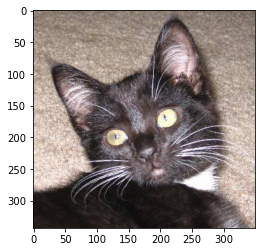

In [24]:
# Testing event
cat_image_url = 'https://s3.amazonaws.com/iguazio-sample-data/images/catanddog/cat.102.jpg'
response = requests.get(cat_image_url)
cat_image = response.content
img = Image.open(BytesIO(cat_image))

print('Test image:')
plt.imshow(img)

### Test The Serving Function (with Image URL)

In [25]:
addr = 'http://nuclio-{}-{}:8080'.format(hvdproj.name, hvdproj.func('serving').metadata.name)

headers = {'Content-type': 'image/jpeg'}
url = addr + f'/cat_vs_dog_tf{tf_ver}/predict'

response = requests.post(url=url, 
                         data=json.dumps({'data_url': cat_image_url}), 
                         headers=headers)
print(response.content.decode('utf-8'))

{"prediction": ["cat"], "dog-probability": [0.0]}


In [31]:
%%timeit 
requests.post(url=url, 
              data=json.dumps({'data_url': cat_image_url}), 
              headers=headers)

849 ms ± 43.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Test The Serving Function (with Jpeg Image)

In [27]:
headers = {'Content-type': 'image/jpeg'}
response = requests.post(url=url, 
                         data=cat_image, 
                         headers=headers)
print(response.content.decode('utf-8'))

{"prediction": ["cat"], "dog-probability": [0.0]}


In [32]:
%%timeit
requests.post(url=url, 
              data=cat_image, 
              headers=headers)

76.3 ms ± 1.56 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


**[back to top](#top)**